# Lesson 5: Choose Your Own Algorithm

Algorithms to choose from:
- Naive Bayes
- SVM
- Decision Tree
- AdaBoost
- Random Forest
- KNN

Data set to evaluate: `makeTerrainData` from `prep_terrain_data`

This is a generated dataset of fake terrain conditions.

Goal: Can You Beat Our High Score? 93.6%

In [1]:
from time import time

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import cache_sklearn_model
from prep_terrain_data import makeTerrainData

## Graph the data

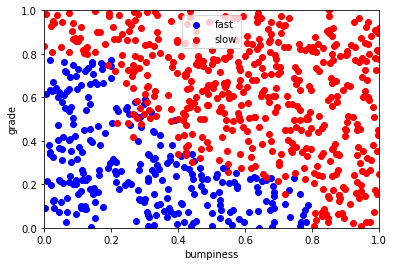

In [2]:
def graph_grade_vs_speed():
    ### the training data (features_train, labels_train) have both "fast" and "slow"
    ### points mixed together--separate them so we can give them different colors
    ### in the scatter plot and identify them visually
    features_train, labels_train, features_test, labels_test = makeTerrainData()
    grade_fast = [features_train[ii][0] for ii in range(0, len(features_train)) if labels_train[ii]==0]
    bumpy_fast = [features_train[ii][1] for ii in range(0, len(features_train)) if labels_train[ii]==0]
    grade_slow = [features_train[ii][0] for ii in range(0, len(features_train)) if labels_train[ii]==1]
    bumpy_slow = [features_train[ii][1] for ii in range(0, len(features_train)) if labels_train[ii]==1]

    #### initial visualization
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.scatter(bumpy_fast, grade_fast, color = "b", label="fast")
    plt.scatter(grade_slow, bumpy_slow, color = "r", label="slow")
    plt.legend()
    plt.xlabel("bumpiness")
    plt.ylabel("grade")
    plt.show()
graph_grade_vs_speed()

## How to Measure success

- what defines a model? model name, params, data_desc
- where can we store meta data on scores against test_data
- save scores to dict so we can see a running tally of the top performing models at any point

In [3]:
classifier_performance_store = {}

In [4]:
def measure_effectiveness_of_classifier(classifier, data_description, features_test, labels_test):
    # identify using: classifier name, classifier params, data desc
    classifier_key = cache_sklearn_model.get_hash_of_model_and_data(classifier, data_description)

    # measure:
    # - inference speed
    t = time()
    labels_pred = classifier.predict(features_test)
    inference_speed = time() - t

    # - accuracy score
    # - recall
    # - precision
    report = classification_report(labels_test, labels_pred, output_dict=True)
    classifier_performance = {
        "key": classifier_key,
        "classifier": type(classifier).__name__,
        "data_description": data_description,
        "params": classifier.get_params(),
        "accuracy": report['accuracy'],
        "recall": report['1']['recall'],
        "precision": report['1']['precision'],
        "f1_score": report['1']['f1-score'],
        "inference_speed": inference_speed,
    }

    if classifier_key in classifier_performance_store:
        print('measurement has already been taken on this model in this configuration')
        print(classifier_performance_store[classifier_key])
        print(classifier_performance)
    else:
        classifier_performance_store[classifier_key] = classifier_performance
        display_classifier_table(classifier_key)

In [5]:
def display_classifier_table(classifier_key = None):
    classifiers_to_display = []
    # requested classifier
    if classifier_key is not None:
        classifiers_to_display.append( classifier_performance_store[classifier_key])
    # top classifiers
    classifiers_to_display.extend(sorted(
        classifier_performance_store.values(),
        key=lambda metric: metric["accuracy"],
        reverse=True
    )[0:5])

    from IPython.display import display, Markdown

    table_header = """
| Accuracy | dataset | classifier | params |
| - | - | - | - |
"""
    table_row_template = "| {accuracy:.3f} | {data_description} | {classifier} | {params} |"
    table_rows = [table_row_template.format(**metric) for metric in classifiers_to_display]

    return display(Markdown(table_header + '\n'.join(table_rows)))